In [1]:
import os
import pandas as pd
from typing import Set, Any, Union, Dict, List, Tuple, Hashable
from langchain.graphs import Neo4jGraph
from langchain.chat_models import ChatOpenAI
from langchain.chains.graph_qa.cypher_utils import CypherQueryCorrector, Schema
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import textdistance
from tqdm.auto import tqdm

tqdm.pandas()

In [2]:
def get_jw_distance(string1: str, string2: str) -> float:
    """
    Calculate the Jaro-Winkler distance between two strings.

    The Jaro-Winkler distance is a measure of similarity between two strings.
    The score is normalized such that 0 equates to no similarity and
    1 is an exact match.
    """
    # Call the jaro_winkler function from the textdistance library.
    return textdistance.jaro_winkler(string1, string2)

In [3]:
def rowsim(setL: Set, setR: Set) -> float:
    """
    Calculate the similarity between two sets using Jaccard index formula.
    """
    return len(setL.intersection(setR)) / len(setL.union(setR))


def floatify(v: Any) -> Any:
    """
    Attempts to convert a value to a float if it is a string and represents a
    number, or recursively apply the conversion to elements within a list or dict.
    """
    if isinstance(v, str):
        return v
    try:
        f = float(v)
        return f
    except:
        pass
    if isinstance(v, list):
        return [floatify(x) for x in v]
    if isinstance(v, dict):
        return {k: floatify(u) for k, u in v.items()}
    return v


def make_hashable(v: Any) -> Hashable:
    """
    Convert a value to a hashable type (needed for set operations).
    """
    float_v = floatify(v)
    if not isinstance(float_v, Hashable):
        return str(float_v)
    else:
        return float_v


def make_alignment(dictL: List[Dict], dictR: List[Dict]) -> Tuple[List[Set], List[Set]]:
    """
    Align rows from two lists of dictionaries based on their similarity.
    """
    swap = len(dictL) > len(dictR)

    # Forming set views from the list of dictionaries.
    setViewsL = [{make_hashable(v) for k, v in row.items()} for row in dictL]
    setViewsR = [{make_hashable(v) for k, v in row.items()} for row in dictR]
    if swap:
        setViewsL, setViewsR = setViewsR, setViewsL

    for i in range(len(setViewsL)):
        max_sim = -1
        max_j = -1
        for j in range(i, len(setViewsR)):
            sim = rowsim(setViewsL[i], setViewsR[j])
            if sim > max_sim:
                max_j = j
                max_sim = sim
        tmp = setViewsR[i]
        setViewsR[i] = setViewsR[max_j]
        setViewsR[max_j] = tmp
    if swap:
        setViewsL, setViewsR = setViewsR, setViewsL
    return setViewsL, setViewsR


def df_sim(dictL: List[Dict], dictR: List[Dict], list_view: bool) -> float:
    """
    Calculate the data frame similarity based on either the original row order or an alignment.
    """
    if list_view:
        # Original row order for lists of dictionaries
        view_L = [row.values() for row in dictL]
        view_R = [row.values() for row in dictR]
    else:
        view_L, view_R = make_alignment(dictL, dictR)

    totalSetL = set()
    for i, s in enumerate(view_L):
        for elem in s:
            totalSetL.add((i, make_hashable(elem)))
    totalSetR = set()
    for i, s in enumerate(view_R):
        for elem in s:
            totalSetR.add((i, make_hashable(elem)))
    intersection = totalSetL.intersection(totalSetR)
    union = totalSetL.union(totalSetR)

    if len(union) == 0 and len(intersection) == 0:
        return 1.0
    elif len(union) == 0:
        return 0.0

    return len(intersection) / len(union)


def df_sim_pair(pair_L, pair_R):
    """
    Compute the Jaccard similarity of two data frames (lists of dictionaries),
    taking into account the order of rows if indicated by the involved Cypher queries.
    """
    cypher_L, dict_L = pair_L
    cypher_R, dict_R = pair_R

    return df_sim(dict_L, dict_R, "order by" in f"{cypher_L} {cypher_R}".lower())

In [4]:
# Example usage (without ORDER BY)
dict_a = [{"id": 2, "value": "B"}, {"id": 1, "value": "A"}]
dict_b = [{"id": 1, "value": "A"}, {"id": 2, "value": "B"}]

query_a = "MATCH (n:TableA) RETURN n.id AS id, n.value AS value"
query_b = "MATCH (n:TableB) RETURN n.id AS id, n.value AS value"

similarity_score = df_sim_pair((query_a, dict_a), (query_b, dict_b))
print(similarity_score)

1.0


In [5]:
# Example usage (different results)
dict_a = [{"id": 2, "value": "B"}, {"id": 1, "value": "A"}, {"id": 1, "value": "A"}]
dict_b = [{"id": 1, "value": "A"}, {"id": 2, "value": "B"}]

query_a = "MATCH (n:TableA) RETURN n.id AS id, n.value AS value"
query_b = "MATCH (n:TableB) RETURN n.id AS id, n.value AS value"

similarity_score = df_sim_pair((query_a, dict_a), (query_b, dict_b))
print(similarity_score)

0.6666666666666666


In [6]:
# Example usage (with ORDER BY)
dict_a = [{"id": 2, "value": "B"}, {"id": 1, "value": "A"}]
dict_b = [{"id": 1, "value": "A"}, {"id": 2, "value": "B"}]

query_a = "MATCH (n:TableA) RETURN n.id AS id, n.value AS value ORDER BY n.id"
query_b = "MATCH (n:TableB) RETURN n.id AS id, n.value AS value ORDER BY n.id"

similarity_score = df_sim_pair((query_a, dict_a), (query_b, dict_b))
print(similarity_score)

0.0


In [7]:
# Example usage (with 1 ORDER BY)
dict_a = [{"id": 2, "value": "B"}, {"id": 1, "value": "A"}]
dict_b = [{"id": 1, "value": "A"}, {"id": 2, "value": "B"}]

query_a = "MATCH (n:TableA) RETURN n.id AS id, n.value AS value ORDER BY n.id"
query_b = "MATCH (n:TableB) RETURN n.id AS id, n.value AS value"

similarity_score = df_sim_pair((query_a, dict_a), (query_b, dict_b))
print(similarity_score)

0.0


In [8]:
# Create a list of dictionaries, each representing a row in the DataFrame
data = [
    {
        "question": "How many movies were released in 1995?",
        "cypher": "MATCH (m:Movie) WHERE m.Year = 1995 RETURN count(*) AS result",
    },
    {
        "question": "Who directed the movie Inception?",
        "cypher": "MATCH (m:Movie {title: 'Inception'})<-[:DIRECTED]-(d) RETURN d.name",
    },
    {
        "question": "Which actors played in the movie Casino?",
        "cypher": "MATCH (m:Movie {title: 'Casino'})<-[:ACTED_IN]-(a) RETURN a.name",
    },
    {
        "question": "How many movies has Tom Hanks acted in?",
        "cypher": "MATCH (a:Actor {name: 'Tom Hanks'})-[:ACTED_IN]->(m:Movie) RETURN count(m)",
    },
    {
        "question": "List all the genres of the movie Schindler's List",
        "cypher": "MATCH (m:Movie {title: 'Schindler\\'s List'})-[:IN_GENRE]->(g:Genre) RETURN g.name",
    },
    {
        "question": "Which actors have worked in movies from both the comedy and action genres?",
        "cypher": "MATCH (a:Actor)-[:ACTED_IN]->(:Movie)-[:IN_GENRE]->(g1:Genre), (a)-[:ACTED_IN]->(:Movie)-[:IN_GENRE]->(g2:Genre) WHERE g1.name = 'Comedy' AND g2.name = 'Action' RETURN DISTINCT a.name",
    },
    {
        "question": "List movies that have an IMDb rating above 8.0 and have grossed over 100 million dollars.",
        "cypher": "MATCH (m:Movie) WHERE m.imdbRating > 8.0 AND m.revenue > 100000000 RETURN m.title, m.imdbRating, m.revenue",
    },
    {
        "question": "Find the top 3 movies with the highest budget in 1995.",
        "cypher": "MATCH (m:Movie) WHERE m.year = 1995 RETURN m.title, m.budget ORDER BY m.budget DESC LIMIT 3",
    },
    {
        "question": "Which directors have made movies with at least three different actors named 'John'?",
        "cypher": "MATCH (d:Director)-[:DIRECTED]->(m:Movie)<-[:ACTED_IN]-(a:Actor) WHERE a.name STARTS WITH 'John' WITH d, COUNT(DISTINCT a) AS JohnsCount WHERE JohnsCount >= 3 RETURN d.name",
    },
    {
        "question": "Identify movies where directors also played a role in the film.",
        "cypher": "MATCH (p:Person)-[:DIRECTED]->(m:Movie), (p)-[:ACTED_IN]->(m) RETURN m.title, p.name",
    },
    {
        "question": "What is the total box-office revenue of all movies released in the 'Fantasy' genre?",
        "cypher": "MATCH (:Genre {name: 'Fantasy'})<-[:IN_GENRE]-(m:Movie) RETURN SUM(m.revenue) AS TotalRevenue",
    },
    {
        "question": "List all users who rated the same movie more than once.",
        "cypher": "MATCH (u:User)-[r:RATED]->(m:Movie) WITH u, m, COUNT(r) AS ratingsCount WHERE ratingsCount > 1 RETURN u.name, m.title, ratingsCount",
    },
    {
        "question": "Find the actor with the highest number of movies in the database.",
        "cypher": "MATCH (a:Actor)-[:ACTED_IN]->(m:Movie) RETURN a.name, COUNT(m) AS movieCount ORDER BY movieCount DESC LIMIT 1",
    },
    {
        "question": "Which movies have a plot that mentions 'revenge' and were released after 2010?",
        "cypher": "MATCH (m:Movie) WHERE m.plot CONTAINS 'revenge' AND m.year > 2010 RETURN m.title, m.released",
    },
    {
        "question": "How many movies are there in each genre?",
        "cypher": "MATCH (g:Genre)<-[:IN_GENRE]-(m:Movie) RETURN g.name, COUNT(m) AS movieCount",
    },
    {
        "question": "What are the names of actors born in 'Dallas, Texas, USA' who have acted in Mystery movies?",
        "cypher": "MATCH (a:Actor {bornIn: 'London'})-[:ACTED_IN]->(:Movie)-[:IN_GENRE]->(:Genre {name: 'Mystery'}) RETURN DISTINCT a.name",
    },
    {
        "question": "Identify the movie with the longest runtime that was released in the 2000s.",
        "cypher": "MATCH (m:Movie) WHERE m.year >= 2000 AND m.year < 2010 RETURN m.title, m.runtime ORDER BY m.runtime DESC LIMIT 1",
    },
    {
        "question": "List the languages available in movies directed by 'Steven Spielberg'.",
        "cypher": "MATCH (d:Director {name: 'Steven Spielberg'})-[:DIRECTED]->(m:Movie) UNWIND m.languages AS language RETURN DISTINCT language",
    },
    {
        "question": "Which movie had the highest IMDb rating in the year Quentin Tarantino was born?",
        "cypher": "MATCH (d:Director {name: 'Quentin Tarantino'}), (m:Movie) WHERE m.year = d.born.year RETURN m.title, m.imdbRating ORDER BY m.imdbRating DESC LIMIT 1",
    },
    {
        "question": "What are the most common genres for movies with a budget over 200 million dollars?",
        "cypher": "MATCH (m:Movie)-[:IN_GENRE]->(g:Genre) WHERE m.budget > 200000000 RETURN g.name, COUNT(*) AS genreCount ORDER BY genreCount DESC",
    },
    {
        "question": "Which countries are represented by at least five movies in the database?",
        "cypher": "MATCH (m:Movie) UNWIND m.countries AS country WITH country, COUNT(m) AS movieCount WHERE movieCount >= 5 RETURN country, movieCount",
    },
    {
        "question": "List all movies that involve time travel in their plot.",
        "cypher": "MATCH (m:Movie) WHERE m.plot CONTAINS 'time travel' RETURN m.title",
    },
    {
        "question": "What are the average IMDb ratings for each year in the 21st century?",
        "cypher": "MATCH (m:Movie) WHERE m.year >= 2000 AND m.year < 2100 WITH m.year AS year, AVG(m.imdbRating) AS avgRating RETURN year, avgRating ORDER BY year",
    },
    {
        "question": "List top 10 actors with the most diverse genres in their filmography.",
        "cypher": "MATCH (a:Actor)-[:ACTED_IN]->(:Movie)-[:IN_GENRE]->(g:Genre) WITH a, COUNT(DISTINCT g) AS genreDiversity ORDER BY genreDiversity DESC LIMIT 10 RETURN a.name, genreDiversity",
    },
    {
        "question": "Which directors have never had a movie with a rating below 6.0?",
        "cypher": "MATCH (d:Director)-[:DIRECTED]->(m:Movie) WITH d, MIN(m.imdbRating) AS lowestRating WHERE lowestRating >= 6.0 RETURN d.name, lowestRating",
    },
    {
        "question": "How many movies have the keyword 'love' in the title and a runtime under 2 hours?",
        "cypher": "MATCH (m:Movie) WHERE m.title CONTAINS 'love' AND m.runtime < 120 RETURN COUNT(m) AS numberOfMovies",
    },
    {
        "question": "Return the list of movies that have a higher IMDb rating than any of 'Tom Hanks' movies.",
        "cypher": "MATCH (m:Movie), (th:Actor {name: 'Tom Hanks'})-[:ACTED_IN]->(tomHanksMovie:Movie) WITH MAX(tomHanksMovie.imdbRating) AS maxTomHanksRating MATCH (m) WHERE m.imdbRating > maxTomHanksRating RETURN m.title, m.imdbRating",
    },
]

# Create the DataFrame
df = pd.DataFrame(data)

In [9]:
df.head()

,question,cypher
0,How many movies were released in 1995?,MATCH (m:Movie) WHERE m.Year = 1995 RETURN cou...
1,Who directed the movie Inception?,MATCH (m:Movie {title: 'Inception'})<-[:DIRECT...
2,Which actors played in the movie Casino?,MATCH (m:Movie {title: 'Casino'})<-[:ACTED_IN]...
3,How many movies has Tom Hanks acted in?,MATCH (a:Actor {name: 'Tom Hanks'})-[:ACTED_IN...
4,List all the genres of the movie Schindler's List,MATCH (m:Movie {title: 'Schindler\'s List'})-[...


In [10]:
os.environ["NEO4J_URI"] = ""
os.environ["NEO4J_USERNAME"] = ""
os.environ["NEO4J_PASSWORD"] = ""
os.environ["OPENAI_API_KEY"] = "sk-"

graph = Neo4jGraph()
llm = ChatOpenAI(model_name="gpt-4-1106-preview", temperature=0)

In [11]:
# Generate Cypher statement based on natural language input
cypher_template = """Based on the Neo4j graph schema below, write a Cypher query that would answer the user's question.
Return only Cypher statement, no backticks, no  nothing else.
{schema}

Question: {question}
Cypher query:"""  # noqa: E501

cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Given an input question, convert it to a Cypher query. No pre-amble.",
        ),
        ("human", cypher_template),
    ]
)

cypher_chain = (
    RunnablePassthrough.assign(
        schema=lambda _: graph.get_schema,
    )
    | cypher_prompt
    | llm.bind(stop=["\nCypherResult:"])
    | StrOutputParser()
)

In [12]:
response = cypher_chain.invoke(
    {
        "question": "How many movies have the keyword 'love' in the title and a runtime under 2 hours?"
    }
)
print(response)

MATCH (m:Movie) WHERE m.title CONTAINS 'love' AND m.runtime < 120 RETURN count(m) as NumberOfMovies


# Code for single run

In [13]:
# Create empty lists to store the results of the new columns
generated_cyphers = []
true_datas = []
eval_datas = []
jaro_winklers = []
pass_1s = []
jaccards = []

# Iterate over each row with tqdm to show a progress bar
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    generated_cypher = cypher_chain.invoke({"question": row["question"]})
    true_data = graph.query(row["cypher"])

    try:
        eval_data = graph.query(generated_cypher)
    except ValueError:
        eval_data = [{"id": "Cypher syntax error"}]

    jaro_winkler = get_jw_distance(row["cypher"], generated_cypher)
    pass_1 = (
        1
        if df_sim_pair((row["cypher"], true_data), (generated_cypher, eval_data)) == 1
        else 0
    )
    jaccard = df_sim_pair((row["cypher"], true_data), (generated_cypher, eval_data))

    # Append the results to their respective lists
    generated_cyphers.append(generated_cypher)
    true_datas.append(true_data)
    eval_datas.append(eval_data)
    jaro_winklers.append(jaro_winkler)
    pass_1s.append(pass_1)
    jaccards.append(jaccard)

# Add the lists as columns to the DataFrame
df["generated_cypher"] = generated_cyphers
df["true_data"] = true_datas
df["eval_data"] = eval_datas
df["jaro_winkler"] = jaro_winklers
df["pass_1"] = pass_1s
df["jaccard"] = jaccards

  0%|          | 0/27 [00:00<?, ?it/s]

In [14]:
row = df.iloc[24]
# Print the desired information
print("Question:", row["question"], "\n")
print("True Cypher:", row["cypher"], "\n")
print("Generated Cypher", row["generated_cypher"], "\n")
# print("True Data:", row['true_data'], "\n")
# print("Eval Data:", row['eval_data'])

Question: Which directors have never had a movie with a rating below 6.0? 

True Cypher: MATCH (d:Director)-[:DIRECTED]->(m:Movie) WITH d, MIN(m.imdbRating) AS lowestRating WHERE lowestRating >= 6.0 RETURN d.name, lowestRating 

Generated Cypher MATCH (d:Director)-[:DIRECTED]->(m:Movie)
WHERE NOT EXISTS {
    MATCH (m)-[r:RATED]->()
    WHERE r.rating < 6.0
}
RETURN DISTINCT d.name 



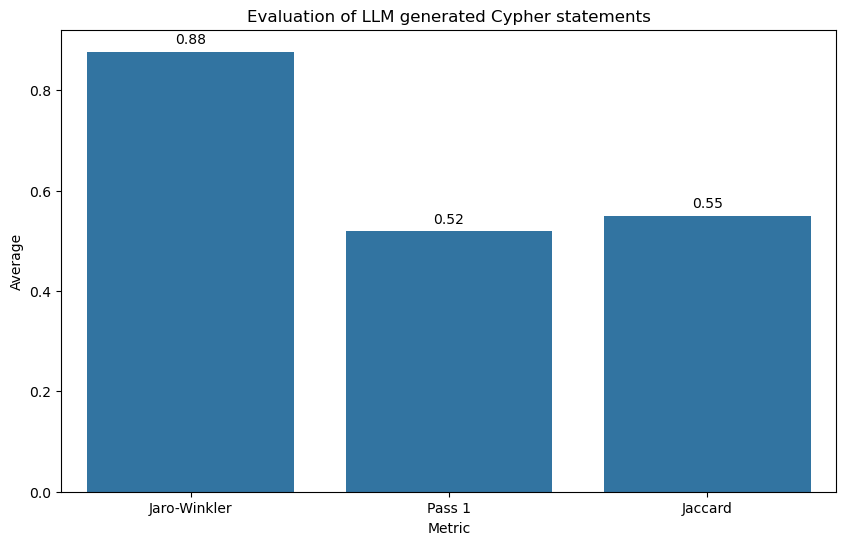

In [15]:
# Calculate the averages of the metrics
avg_jaro_winkler = df["jaro_winkler"].mean()
avg_pass_1 = df["pass_1"].mean()
avg_jaccard = df["jaccard"].mean()

# Prepare the data for visualization
averages = pd.DataFrame(
    {
        "Metric": ["Jaro-Winkler", "Pass 1", "Jaccard"],
        "Average": [avg_jaro_winkler, avg_pass_1, avg_jaccard],
    }
)

# Create the bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x="Metric", y="Average", data=averages)

# Annotate the bars with the actual average values
for p in barplot.patches:
    barplot.annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
    )

# Set the title and labels
plt.title("Evaluation of LLM generated Cypher statements")
plt.ylabel("Average")
plt.xlabel("Metric")

# Show the plot
plt.show()

# Code for multiple runs

In [16]:
# Number of runs
num_runs = 3

# A list to collect average metrics across all runs
all_runs_averages = []

# Perform 3 runs of evaluation
for run in range(num_runs):
    print(f"Starting run {run+1}/{num_runs}")
    generated_cyphers = []
    true_datas = []
    eval_datas = []
    jaro_winklers = []
    pass_1s = []
    jaccards = []

    # Your data processing code with tqdm progress bar
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        generated_cypher = cypher_chain.invoke({"question": row["question"]})
        true_data = graph.query(row["cypher"])

        try:
            eval_data = graph.query(generated_cypher)
        except ValueError:
            eval_data = [{"id": "Cypher syntax error"}]

        jaro_winkler = get_jw_distance(row["cypher"], generated_cypher)
        pass_1 = (
            1
            if df_sim_pair((row["cypher"], true_data), (generated_cypher, eval_data))
            == 1
            else 0
        )
        jaccard = df_sim_pair((row["cypher"], true_data), (generated_cypher, eval_data))

        generated_cyphers.append(generated_cypher)
        true_datas.append(true_data)
        eval_datas.append(eval_data)
        jaro_winklers.append(jaro_winkler)
        pass_1s.append(pass_1)
        jaccards.append(jaccard)

    # Calculate the averages of the metrics for this run
    avg_jaro_winkler = sum(jaro_winklers) / len(jaro_winklers)
    avg_pass_1 = sum(pass_1s) / len(pass_1s)
    avg_jaccard = sum(jaccards) / len(jaccards)

    # Collect averages for this run
    run_averages = {
        "Run": run + 1,
        "Jaro-Winkler": avg_jaro_winkler,
        "Pass 1": avg_pass_1,
        "Jaccard": avg_jaccard,
    }
    all_runs_averages.append(run_averages)

Starting run 1/3


  0%|          | 0/27 [00:00<?, ?it/s]

Starting run 2/3


  0%|          | 0/27 [00:00<?, ?it/s]

Starting run 3/3


  0%|          | 0/27 [00:00<?, ?it/s]

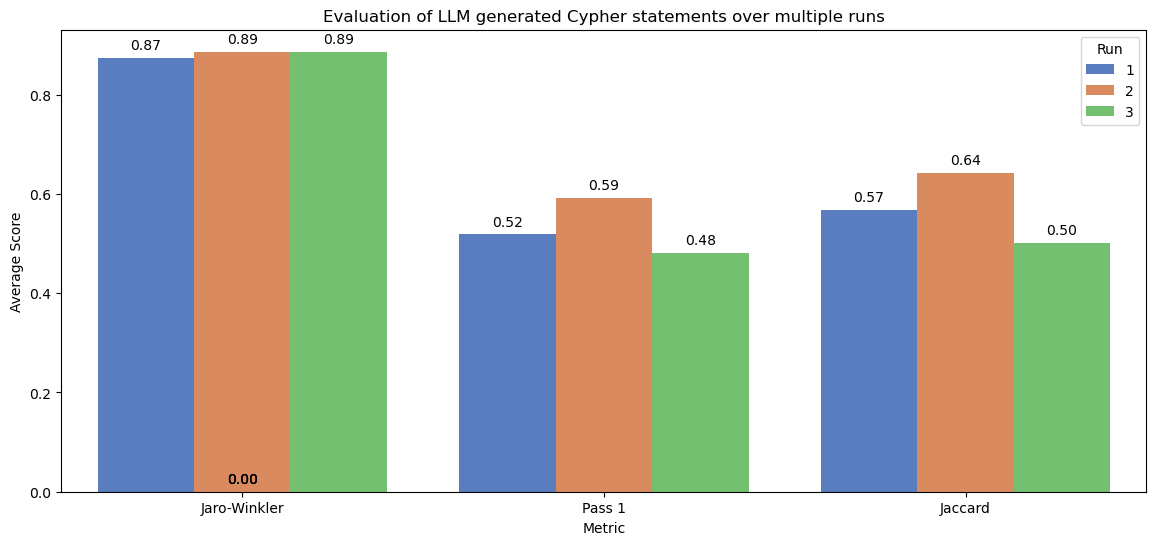

In [25]:
# Convert collected metrics to a DataFrame
all_runs_averages_df = pd.DataFrame(all_runs_averages)

# Melt the DataFrame for better plotting
all_runs_averages_melted = all_runs_averages_df.melt(
    id_vars=["Run"], var_name="Metric", value_name="Average"
)

# Create the bar plot with facet by runs
plt.figure(figsize=(14, 6))
barplot = sns.barplot(
    x="Metric", y="Average", hue="Run", data=all_runs_averages_melted, palette="muted"
)

# Annotate the bars with the actual average values
for p in barplot.patches:
    barplot.annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
    )

# Set the title and labels
plt.title("Evaluation of LLM generated Cypher statements over multiple runs")
plt.ylabel("Average Score")
plt.xlabel("Metric")
plt.legend(title="Run")

# Show the plot
plt.show()